In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from dataloader import TRAILDataset
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Functions

In [3]:
def create_sequence_dataset(data, lookback, output_length=4):
    X, y = [], []
    for i in tqdm(range(0, len(data) - lookback - output_length + 1, output_length), desc="Generating sequences"):
        
        X.append(data.iloc[i : i + lookback, :].values)
        y.append(data.iloc[i + lookback : i + lookback + output_length, -1].values)
    
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    
    return X_tensor, y_tensor

In [4]:
def validate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc='Validation', position=0, leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [5]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in tqdm(train_loader, desc='Training',position=0, leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss = validate_model(model, criterion, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    print('Finished Training')
    
    return train_losses, val_losses


In [6]:
def denorm_tensor(x, min_, max_):
    return x * (max_ - min_) + min_

In [7]:
def test_model(model, test_loader, predict_scaler):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc='Validation', position=0, leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            # apply reverse scaling
            max_ = torch.tensor(predict_scaler.data_max_).to(device)
            min_ = torch.tensor(predict_scaler.data_min_).to(device)
            
            y_batch_ = denorm_tensor(y_batch, min_, max_)
            outputs_ = denorm_tensor(outputs, min_, max_)
        
            y_true.append(y_batch_)
            y_pred.append(outputs_)
    
    
    y_true = [tensor.cpu().numpy() for tensor in y_true]
    y_pred = [tensor.cpu().numpy() for tensor in y_pred]
    
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    
    mse_per_output = []
    rmse_per_output = []
    mape_per_output = []
    
    for i in range(y_true.shape[1]):
        mse_value = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse_value = np.sqrt(mse_value)
        mape_value = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i])

        mse_per_output.append(mse_value)
        rmse_per_output.append(rmse_value)
        mape_per_output.append(mape_value)

        print(f"Output {i+1}: MSE: {mse_value:.4f}, RMSE: {rmse_value:.4f}, MAPE: {mape_value:.4f}%")
        
    
    return mse_per_output, rmse_per_output, mape_per_output

In [8]:
def get_predictions(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            
            y_true.append(y_batch.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
    
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    
    return y_true, y_pred

In [9]:
def plot_true_vs_predicted(y_true, y_pred, time=None):
    if time is None:
        time = np.arange(len(y_true))
    
    plt.figure(figsize=(18, 6))
    plt.plot(time, y_true, color='blue', label='True Values')
    plt.plot(time, y_pred, color='red', label='Predicted Values')
    
    plt.ylabel('Total Load')
    plt.title('True Values vs Predicted Values')
    plt.legend()
    plt.show()


In [10]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
def denorm_tensor(x, min_, max_):
    return x * (max_ - min_) + min_

**RNN**

In [12]:
LAG = 8
HORIZON = 4
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 8

In [13]:
class RNNVectorOutput(nn.Module):
    def __init__(self,input_size, output_size, num_layers=2):
        super(RNNVectorOutput, self).__init__()
        self.lstm = nn.RNN(input_size=input_size, hidden_size=32, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(32, output_size)
        self.sigmoid = nn.Sigmoid()  
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x =  F.tanh(x)
        x = self.linear(x[:, -1, :])
        x =   F.tanh(x)
        return x

Loading the data and splitting it into training, validation, and test sets

In [14]:
csv_file = "Processed_data.csv"
df = pd.read_csv(csv_file, sep=",") 
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Weekday'] = df['Datetime'].dt.weekday
df = df.set_index('Datetime')

In [15]:
df_train = df[df["Year"] < 2022]
df_val = df[df["Year"] == 2022]
df_test = df[df["Year"] == 2023]

In [16]:
# Final test set
df.iloc[335428 : 338404].to_csv('truth.csv', index = False)

df_final_test = df.iloc[335428-LAG : 338404]

In [18]:
columns_input = ['Hour','Weekday', 'Month','Total Load Interpolated']  
column_to_predict = 'Total Load Interpolated'
column_to_normalize = ['Total Load Interpolated']

In [19]:
train_dataset = TRAILDataset(df_train, len(df_train), columns_input, column_to_predict, column_to_normalize)

scaler = train_dataset.get_scaler()
predict_scaler = train_dataset.get_predict_scaler()

train_dataset.save_scaler()

predict_scaler = train_dataset.get_predict_scaler()
print("train dataset loaded")
print(column_to_normalize)

val_dataset = TRAILDataset(df_val, len(df_val), columns_input, column_to_predict, column_to_normalize, scaler=scaler, predict_scaler=predict_scaler)
print("validation dataset loaded")

test_dataset = TRAILDataset(df_test, len(df_test), columns_input, column_to_predict, column_to_normalize, scaler=scaler, predict_scaler=predict_scaler)
print("test dataset loaded")



final_test_dataset = TRAILDataset(df_final_test, len(df_final_test), columns_input, column_to_predict, column_to_normalize, scaler=scaler, predict_scaler=predict_scaler)
print("final test dataset loaded")


train dataset loaded
['Total Load Interpolated']
validation dataset loaded
test dataset loaded
final test dataset loaded


c:\Users\tojov\Desktop\Workshop_2024\project9\dataloader.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.column_to_predict] = scaled_row
c:\Users\tojov\Desktop\Workshop_2024\project9\dataloader.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.column_to_predict] = scaled_row
c:\Users\tojov\Desktop\Workshop_2024\project9\dataloader.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Sequence generation

In [20]:
X_train, y_train = create_sequence_dataset( train_dataset.data[columns_input], lookback=LAG, output_length=HORIZON)
X_val, y_val = create_sequence_dataset( val_dataset.data[columns_input], lookback=LAG, output_length=HORIZON)
X_test, y_test = create_sequence_dataset( test_dataset.data[columns_input], lookback=LAG, output_length=HORIZON)

X_final_test, y_final_test = create_sequence_dataset( final_test_dataset.data[columns_input], lookback=LAG, output_length=HORIZON)

Generating sequences: 100%|██████████| 61367/61367 [00:08<00:00, 6971.29it/s]
c:\Python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  del sys.path[0]
Generating sequences: 100%|██████████| 744/744 [00:00<00:00, 6951.76it/s]


In [21]:
X_train.shape

torch.Size([61367, 8, 4])

In [22]:
X_train.shape, y_train.shape

(torch.Size([61367, 8, 4]), torch.Size([61367, 4]))

In [23]:
import torch.utils.data as data

train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(data.TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

final_test_loader = data.DataLoader(data.TensorDataset(X_final_test, y_final_test), batch_size=BATCH_SIZE, shuffle=False)

Model creation and training

In [24]:
model =  RNNVectorOutput(input_size=len(columns_input),output_size=HORIZON, num_layers= 4)

In [25]:
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [26]:
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS)  

Training:   0%|          | 0/7671 [00:00<?, ?it/s]C:\Users\tojov\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1/50, Training Loss: 0.0068, Validation Loss: 0.0127


Epoch 2/50, Training Loss: 0.0034, Validation Loss: 0.0059


Epoch 3/50, Training Loss: 0.0022, Validation Loss: 0.0037


Epoch 4/50, Training Loss: 0.0018, Validation Loss: 0.0036


Epoch 5/50, Training Loss: 0.0015, Validation Loss: 0.0031


Epoch 6/50, Training Loss: 0.0013, Validation Loss: 0.0025


Epoch 7/50, Training Loss: 0.0013, Validation Loss: 0.0019


Epoch 8/50, Training Loss: 0.0013, Validation Loss: 0.0026


Epoch 9/50, Training Loss: 0.0013, Validation Loss: 0.0047


Epoch 10/50, Training Loss: 0.0011, Validation Loss: 0.0018


Epoch 11/50, Training Loss: 0.0010, Validation Loss: 0.0019


Epoch 12/50, Training Loss: 0.0011, Validation Loss: 0.0034


Epoch 13/50, Training Loss: 0.0010, Validation Loss: 0.0018


Epoch 14/50, Training Loss: 0.0010, Validation Loss: 0.0020


Epoch 15/50, Training Loss: 0.0009, Validation Loss: 0.0014


Epoch 16/50, Training Loss: 0.0008, Validation Loss: 0.0012


Epoch 17/50, Training Loss: 0.0010, Validation Loss: 0.0012


Epoch 18/50, Training Loss: 0.0010, Validation Loss: 0.0018


Epoch 19/50, Training Loss: 0.0009, Validation Loss: 0.0017


Epoch 20/50, Training Loss: 0.0008, Validation Loss: 0.0017


Epoch 21/50, Training Loss: 0.0009, Validation Loss: 0.0014


Epoch 22/50, Training Loss: 0.0008, Validation Loss: 0.0014


Epoch 23/50, Training Loss: 0.0008, Validation Loss: 0.0014


Epoch 24/50, Training Loss: 0.0008, Validation Loss: 0.0015


Epoch 25/50, Training Loss: 0.0007, Validation Loss: 0.0012


Epoch 26/50, Training Loss: 0.0007, Validation Loss: 0.0012


Epoch 27/50, Training Loss: 0.0007, Validation Loss: 0.0012


Epoch 28/50, Training Loss: 0.0007, Validation Loss: 0.0012


Epoch 29/50, Training Loss: 0.0007, Validation Loss: 0.0011


Epoch 30/50, Training Loss: 0.0007, Validation Loss: 0.0011


Epoch 31/50, Training Loss: 0.0006, Validation Loss: 0.0011


Epoch 32/50, Training Loss: 0.0006, Validation Loss: 0.0010


Epoch 33/50, Training Loss: 0.0006, Validation Loss: 0.0011


Epoch 34/50, Training Loss: 0.0006, Validation Loss: 0.0011


Epoch 35/50, Training Loss: 0.0006, Validation Loss: 0.0011


Epoch 36/50, Training Loss: 0.0006, Validation Loss: 0.0011


Epoch 37/50, Training Loss: 0.0006, Validation Loss: 0.0012


Epoch 38/50, Training Loss: 0.0006, Validation Loss: 0.0010


Epoch 39/50, Training Loss: 0.0006, Validation Loss: 0.0010


Epoch 40/50, Training Loss: 0.0006, Validation Loss: 0.0010


Epoch 41/50, Training Loss: 0.0006, Validation Loss: 0.0011


Epoch 42/50, Training Loss: 0.0006, Validation Loss: 0.0010


Epoch 43/50, Training Loss: 0.0006, Validation Loss: 0.0010


Epoch 44/50, Training Loss: 0.0006, Validation Loss: 0.0010


Epoch 45/50, Training Loss: 0.0006, Validation Loss: 0.0010


Epoch 46/50, Training Loss: 0.0006, Validation Loss: 0.0010


Epoch 47/50, Training Loss: 0.0006, Validation Loss: 0.0010


Epoch 48/50, Training Loss: 0.0006, Validation Loss: 0.0010


Epoch 49/50, Training Loss: 0.0005, Validation Loss: 0.0010


Epoch 50/50, Training Loss: 0.0006, Validation Loss: 0.0010
Finished Training


#### **Training / Validation curves**

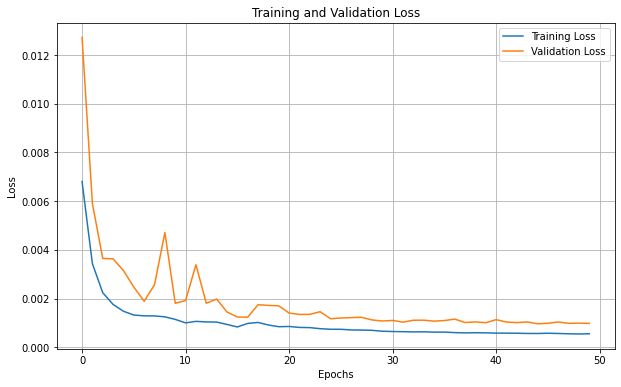

In [27]:
plot_losses(train_losses, val_losses)

#### **Evaluation on 2023 data**

In [28]:
mse_values, rmse_values, mape_values = test_model(model, test_loader, predict_scaler)

Output 1: MSE: 58646.4434, RMSE: 242.1703, MAPE: 0.0223%
Output 2: MSE: 75177.9409, RMSE: 274.1860, MAPE: 0.0253%
Output 3: MSE: 91562.2077, RMSE: 302.5925, MAPE: 0.0279%
Output 4: MSE: 111063.4514, RMSE: 333.2618, MAPE: 0.0307%


In [29]:
y_true, y_pred = get_predictions(model, test_loader)
y_true, y_pred = y_true.reshape(-1) , y_pred.reshape(-1)

# apply reverse scaling
y_true = predict_scaler.inverse_transform(y_true.reshape(-1,1))
y_pred = predict_scaler.inverse_transform(y_pred.reshape(-1,1))


C:\Users\tojov\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


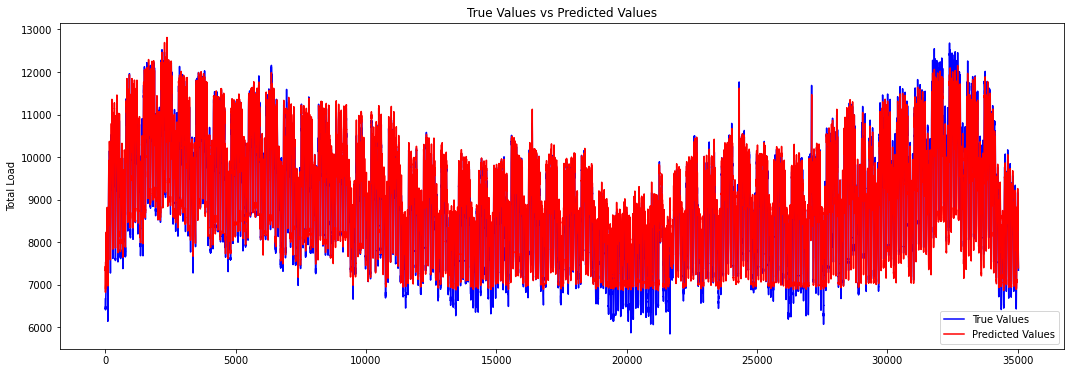

In [30]:
plot_true_vs_predicted(y_true, y_pred)

### **Evaluation on the last month of 2024**

In [31]:
# evaluation on final Test
mse_values, rmse_values, mape_values = test_model(model, final_test_loader, predict_scaler)

Validation:   0%|          | 0/93 [00:00<?, ?it/s]C:\Users\tojov\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
                                                            

Output 1: MSE: 49175.3795, RMSE: 221.7552, MAPE: 0.0220%
Output 2: MSE: 66299.2917, RMSE: 257.4865, MAPE: 0.0259%
Output 3: MSE: 86183.6320, RMSE: 293.5705, MAPE: 0.0298%
Output 4: MSE: 111379.7320, RMSE: 333.7360, MAPE: 0.0342%


In [32]:
y_true, y_pred = get_predictions(model, final_test_loader)
y_true, y_pred = y_true.reshape(-1) , y_pred.reshape(-1)

# apply reverse scaling
y_true = predict_scaler.inverse_transform(y_true.reshape(-1,1))
y_pred = predict_scaler.inverse_transform(y_pred.reshape(-1,1))


C:\Users\tojov\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


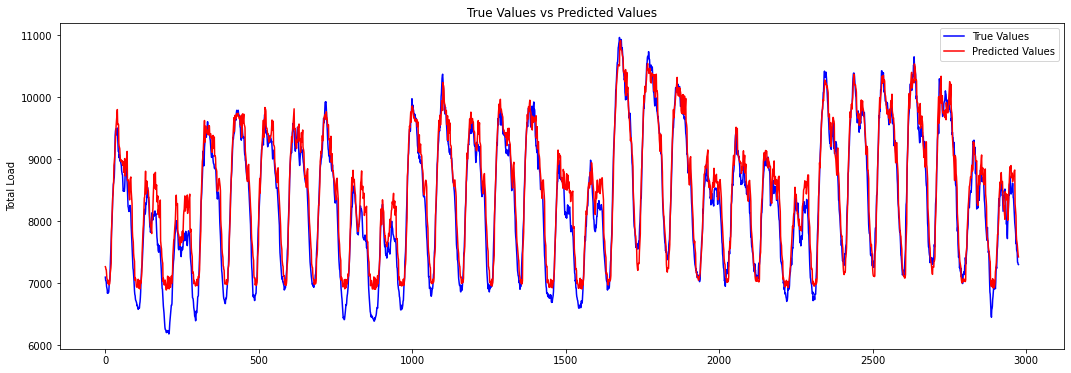

In [33]:
plot_true_vs_predicted(y_true, y_pred)

In [34]:
# saving prediction to csv file
pd.DataFrame(y_pred, columns=['Prediction']).to_csv('mlp_result.csv',index=False)

In [35]:
predictions = pd.read_csv('mlp_result.csv')
truth = pd.read_csv("truth.csv")

t0_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][::4], predictions["Prediction"][::4]))
t1_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][1::4], predictions["Prediction"][1::4]))
t2_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][2::4], predictions["Prediction"][2::4]))
t3_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][3::4], predictions["Prediction"][3::4]))

t0_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][::4], predictions["Prediction"][::4])
t1_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][1::4], predictions["Prediction"][1::4])
t2_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][2::4], predictions["Prediction"][2::4])
t3_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][3::4], predictions["Prediction"][3::4])

print("|Model Name|RMSE t+1|RMSE t+2|RMSE t+3|RMSE t+4|MAPE t+1|MAPE t+2|MAPE t+3|MAPE t+4|")
print("| |", str(t0_rmse)[:7], "|", str(t1_rmse)[:7], "|", str(t2_rmse)[:7], "|", str(t3_rmse)[:7],
      "|", str(t0_mape)[:7], "|", str(t1_mape)[:7], "|", str(t2_mape)[:7], "|", str(t3_mape)[:7], "|", sep="")

|Model Name|RMSE t+1|RMSE t+2|RMSE t+3|RMSE t+4|MAPE t+1|MAPE t+2|MAPE t+3|MAPE t+4|
| |221.755|257.486|293.570|333.735|0.02200|0.02589|0.02978|0.03423|


In [36]:
!python evaluate.py mlp_result.csv

Traceback (most recent call last):
  File "evaluate.py", line 2, in <module>
    from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
ImportError: cannot import name 'root_mean_squared_error' from 'sklearn.metrics' (c:\Python37\lib\site-packages\sklearn\metrics\__init__.py)
